In [1]:
#
# Run the hbv parameter estimation with full model
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/hbv_det.m
#

In [44]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd
from scipy.stats import t
from scipy.linalg import eig

In [3]:
filename = 'hbv_data.csv'
D_frame = read_file(filename, directory = 'data_sets')

read dir : /home/paperspace/learn_kipet/kipet_paresto/data_sets/hbv_data.csv


In [4]:
D_frame.shape

(50, 3)

In [6]:
D_frame.head()

,A,B,C
0.000000,1.051482,-0.000739,-0.000501
2.040816,0.718060,2.599459,371.265832
4.081633,0.641247,5.702485,325.080882
6.122449,0.657471,6.944847,296.171685
8.163265,0.772015,9.147780,291.254375


In [7]:
x = np.array([0.80, -1.13, 3.15, -0.77, -0.16, -5.46])
10**x

array([6.30957344e+00, 7.41310241e-02, 1.41253754e+03, 1.69824365e-01,
       6.91830971e-01, 3.46736850e-06])

In [31]:
builder = TemplateBuilder()    
components = {'A':1,'B':0,'C':0}
builder.add_mixture_component(components)
#builder.add_parameter('k1',initialize = 6.3, bounds=(0.0,5e3))
#builder.add_parameter('k2',initialize = 7.4e-2, bounds=(0.0,5e3))
#builder.add_parameter('k3',initialize = 1.4e3, bounds=(0.0,5e3))
#builder.add_parameter('k4',initialize = 1.7e-1, bounds=(0.0,5e3))
#builder.add_parameter('k5',initialize = 6.9e-1, bounds=(0.0,5e3))
#builder.add_parameter('k6',initialize = 3.5e-6, bounds=(0.0,5e3))

builder.add_parameter('k1',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k2',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k3',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k4',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k5',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k6',initialize = 100, bounds=(0.0,5e3))

builder.add_concentration_data(D_frame)

Warning! Since C-matrix contains negative values Kipet is assuming a derivative of C has been inputted


In [32]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = m.P['k2']*m.Z[t,'B'] - m.P['k4']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']-m.P['k6']*m.Z[t,'B']*m.Z[t,'C']
    exprs['C'] = m.P['k3']*m.Z[t,'A']-m.P['k5']*m.Z[t,'C']-m.P['k6']*m.Z[t,'B']*m.Z[t,'C']
    return exprs

builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,100.0)

In [33]:
sigmas = {'A':1, 'B':100, 'C':1e4}
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=50,ncp=3,scheme='LAGRANGE-RADAU')

In [34]:
options = dict()
results_pyomo = p_estimator.run_opt('k_aug',
                                    variances=sigmas,
                                  tee=True,
                                  solver_opts = options,
                                  covariance=True)

        0.13 seconds required to write file
        0.13 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1350

Total number of variables............................:      909
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
T

  81  1.3061424e+06 1.36e+01 9.38e+05  -1.7 9.41e+01  -0.4 1.00e+00 1.21e-01h  1
  82  1.3100186e+06 5.43e-01 1.04e+06  -1.7 1.00e+02  -0.9 8.88e-01 1.00e+00h  1
  83  1.3083403e+06 1.87e-01 1.65e+06  -1.7 1.68e+02  -1.4 4.56e-02 1.00e+00f  1
  84  1.3041354e+06 1.83e+00 3.79e+05  -1.7 4.42e+02  -1.9 8.16e-04 1.00e+00f  1
  85  1.3010376e+06 1.16e+00 2.16e+05  -1.7 1.76e+02  -1.4 1.00e+00 1.00e+00f  1
  86  1.2990601e+06 1.73e+00 3.59e+05  -1.7 7.98e+04  -1.9 5.78e-02 2.62e-03f  1
  87  1.2957066e+06 2.00e+00 8.79e+05  -1.7 4.46e+01  -1.5 1.12e-02 1.00e+00f  1
  88  1.2917277e+06 2.11e+00 6.94e+05  -1.7 5.42e+01  -2.0 1.00e+00 1.00e+00f  1
  89  1.2904140e+06 5.53e+00 4.27e+05  -1.7 7.11e+01  -2.4 1.00e+00 5.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.2898754e+06 8.53e+00 2.38e+05  -1.7 1.78e+02  -2.9 2.43e-02 1.00e+00f  1
  91  1.2896763e+06 4.01e+00 1.33e+04  -1.7 6.16e+02  -3.4 5.94e-01 1.00e+00f  1
  92  1.2895342e+06 1.24e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.5780471e+04 1.90e-11 4.57e-07  -3.8 2.85e-07    -  1.00e+00 1.00e+00h  1
 181  1.5780471e+04 2.32e-11 4.30e-06  -5.7 8.59e-05    -  1.00e+00 1.00e+00h  1
 182  1.5780471e+04 1.68e-11 6.77e-07  -8.6 1.07e-06    -  1.00e+00 1.00e+00h  1
 183  1.5780471e+04 2.35e-11 3.40e-08  -8.6 9.86e-12    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 183

                                   (scaled)                 (unscaled)
Objective...............:   1.5221977126780404e+04    1.5780470851053991e+04
Dual infeasibility......:   3.3993033853298853e-08    3.5240236888618519e-08
Constraint violation....:   2.3526069981016917e-11    2.3526069981016917e-11
Complementarity.........:   2.5059035596800622e-09    2.5978450597926808e-09
Overall NLP error.......:   8.7578438006715495e-09    3.5240236888618519e-08


Number of objective function evaluations             = 234
Number of objective gradient evaluations      

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018



W[K_AUG]...	[K_AUG_ASL]Variable "455" (offset 6) has an active bound; sigma = 34.958884.


: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 909
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 6
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.585386754603892 at var_i=450
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.585386754603892 at var_i=451
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 5103
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 1350
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 15780.470851
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 759
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_RH]Accordin

In [36]:
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 2.104144283485429
k2 0.021076208210646007
k3 149.41110853772145
k4 0.21295003420721242
k5 0.29056702429607545
k6 8.61040838358159e-06


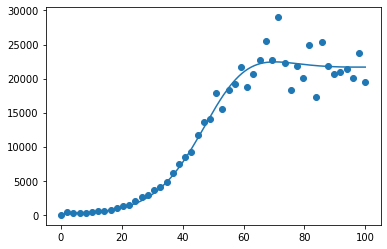

In [40]:
fig, ax = plt.subplots()
c='C'
ax.scatter(D_frame.index, D_frame[c])
ax.plot(results_pyomo.Z.index, results_pyomo.Z[c])

In [24]:
results_pyomo.objective

15780.470851053991

In [41]:
# since kipet outputs reduced hessian which equals covariance if right sigma values are specified. 
# since we just specified sigma=1, we need to adjust the covariance matrix output from KIPET to get the 
# estimated covariance matrix
mse = results_pyomo.objective / (50*3 - 6)
cov_est = 2 * mse * results_pyomo.parameter_covariance
cov_est

array([[ 2.23603297e-02, -1.40344920e-03, -1.03684892e+00,
        -1.35277315e-02, -2.83368028e-03,  1.39950384e-07],
       [-1.40344920e-03,  1.42668084e-04,  1.30290118e-01,
         1.50347671e-03,  2.60413106e-04, -1.59092047e-08],
       [-1.03684892e+00,  1.30290118e-01,  7.84800012e+02,
         1.44165757e+00,  1.50600685e+00, -1.80216554e-05],
       [-1.35277315e-02,  1.50347671e-03,  1.44165757e+00,
         1.60476716e-02,  2.73684839e-03, -1.71058663e-07],
       [-2.83368028e-03,  2.60413106e-04,  1.50600685e+00,
         2.73684839e-03,  3.08435682e-03, -3.28003086e-08],
       [ 1.39950384e-07, -1.59092047e-08, -1.80216554e-05,
        -1.71058663e-07, -3.28003086e-08,  1.86876103e-12]])

In [42]:
dof = 50*3 - 5
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_est))
conf_delta

array([2.95547326e-01, 2.36075733e-02, 5.53690961e+01, 2.50376721e-01,
       1.09766607e-01, 2.70187229e-06])

In [43]:
# confidence limits of parameters
i = 0
for k, v in six.iteritems(results_pyomo.P):
    print(f"{k}, {v - conf_delta[i]}, {v + conf_delta[i]}, {conf_delta[i]/v}, {np.log10(v)}")
    i = i + 1

k1, 1.8085969575278669, 2.3996916094429914, 0.14045962925508143, 0.32307551655257494
k2, -0.002531365137671774, 0.044683781558963784, 1.120105339270331, -1.6762075197079045
k3, 94.04201242082583, 204.78020465461708, 0.37058219203906595, 2.1743828879565332
k4, -0.037426686719160385, 0.46332675513358523, 1.1757533726561513, -0.6717222858273659
k5, 0.18080041714663025, 0.40033363144552064, 0.37776691080264396, -0.5367536742047444
k6, 5.90853609039085e-06, 1.131228067677233e-05, 0.3137914222910375, -5.064976249878524
